* reference: 
    * basic: https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/learning_rate_schedules.html
    * advanced: https://mxnet.incubator.apache.org/versions/master/tutorials/gluon/learning_rate_schedules_advanced.html  


In [124]:
import matplotlib.pyplot as plt
from __future__ import print_function
import math
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
import numpy as np
import copy
%matplotlib inline

In [110]:
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.style.use('ggplot')
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

### Basic Part

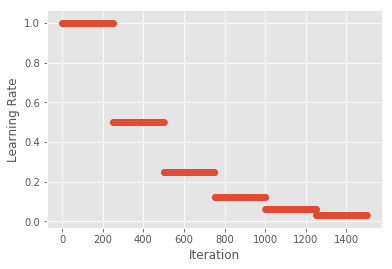

In [80]:
schedule = mx.lr_scheduler.FactorScheduler(step=250, factor=0.5)
schedule.base_lr = 1
plot_schedule(schedule)

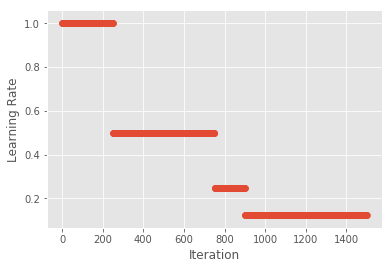

In [81]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
plot_schedule(schedule)

不过使用FactorScheduler需要提前计算decay steps。通常情况下指定decay_epochs更为方便。我们可以通过下面的代码将steps转换为epochs:  
```python 
steps_epochs = [30, 60, 90]
num_steps_per_epoch = len(data_iter)
# num_steps_per_epoch = len(dataset)/batchsize
steps_iterations = [s*num_steps_per_epoch for s in steps_epochs]
schedule = mx.lr_scheduler.MultiFactorScheduler(step=steps_iterations, factor=0.1)
sgd_optimizer = mx.optimizer.SGD(learning_rate=0.03, lr_scheduler=schedule)
trainer = mx.gluon.Trainer(params=net.collect_params(), optimizer=sgd_optimizer)

```

* Polynomial Deacy

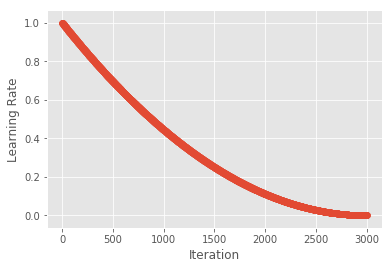

In [71]:
schedule = mx.lr_scheduler.PolyScheduler(max_update=3000, base_lr=1, pwr=2)
plot_schedule(schedule,3000)

### Advanced Part

* TriangularSchedule  

主要思想：  

1.训练开始阶段使用一个较平滑的"linear warm up"有助于提高稳定性并收敛到更加结果。进一步推出：smooth decay gives improved performance.这个结论跟之前看到一篇论文中结论相反，回头找一下是哪篇论文。  
2.Quite simply, the schedule linearly increases then decreases between a lower and upper bound. Originally it was suggested this schedule be used as part of a cyclical schedule but more recently researchers have been using a single cycle.  
3.刚提出来时用的是等腰三角形schedule。后来改进为斜三角形：即increasing fraction < 0.5，这样可以给出更好的结果

In [72]:
class TrianguarSchedule:
    def __init__(self, min_lr, max_lr, cycle_length, in_fraction=0.5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.end_increase = in_fraction * cycle_length
        
    def __call__(self, iteration):
        if iteration < self.end_increase:
            unit_cycle = iteration / self.end_increase
        elif iteration < self.cycle_length:
            unit_cycle = 1 - (iteration - self.end_increase) / (self.cycle_length - self.end_increase)
        else:
            unit_cycle = 0
        curr_lr = unit_cycle * (self.max_lr - self.min_lr) + self.min_lr
        return curr_lr

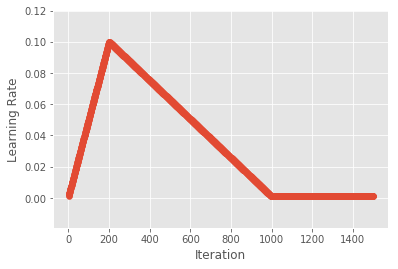

In [73]:
schedule = TrianguarSchedule(0.001, 0.1, 1000, 0.2)
plot_schedule(schedule)

* Cosine Annealing  
这一部分非常值得关注，因为大名鼎鼎的SGDR（Stochastic Gradient Descent with Warm Restarts）其实就是Cyclical Cosine Annealing。该方法是上面的思想: "smooth decay improves performance"的进一步延伸。

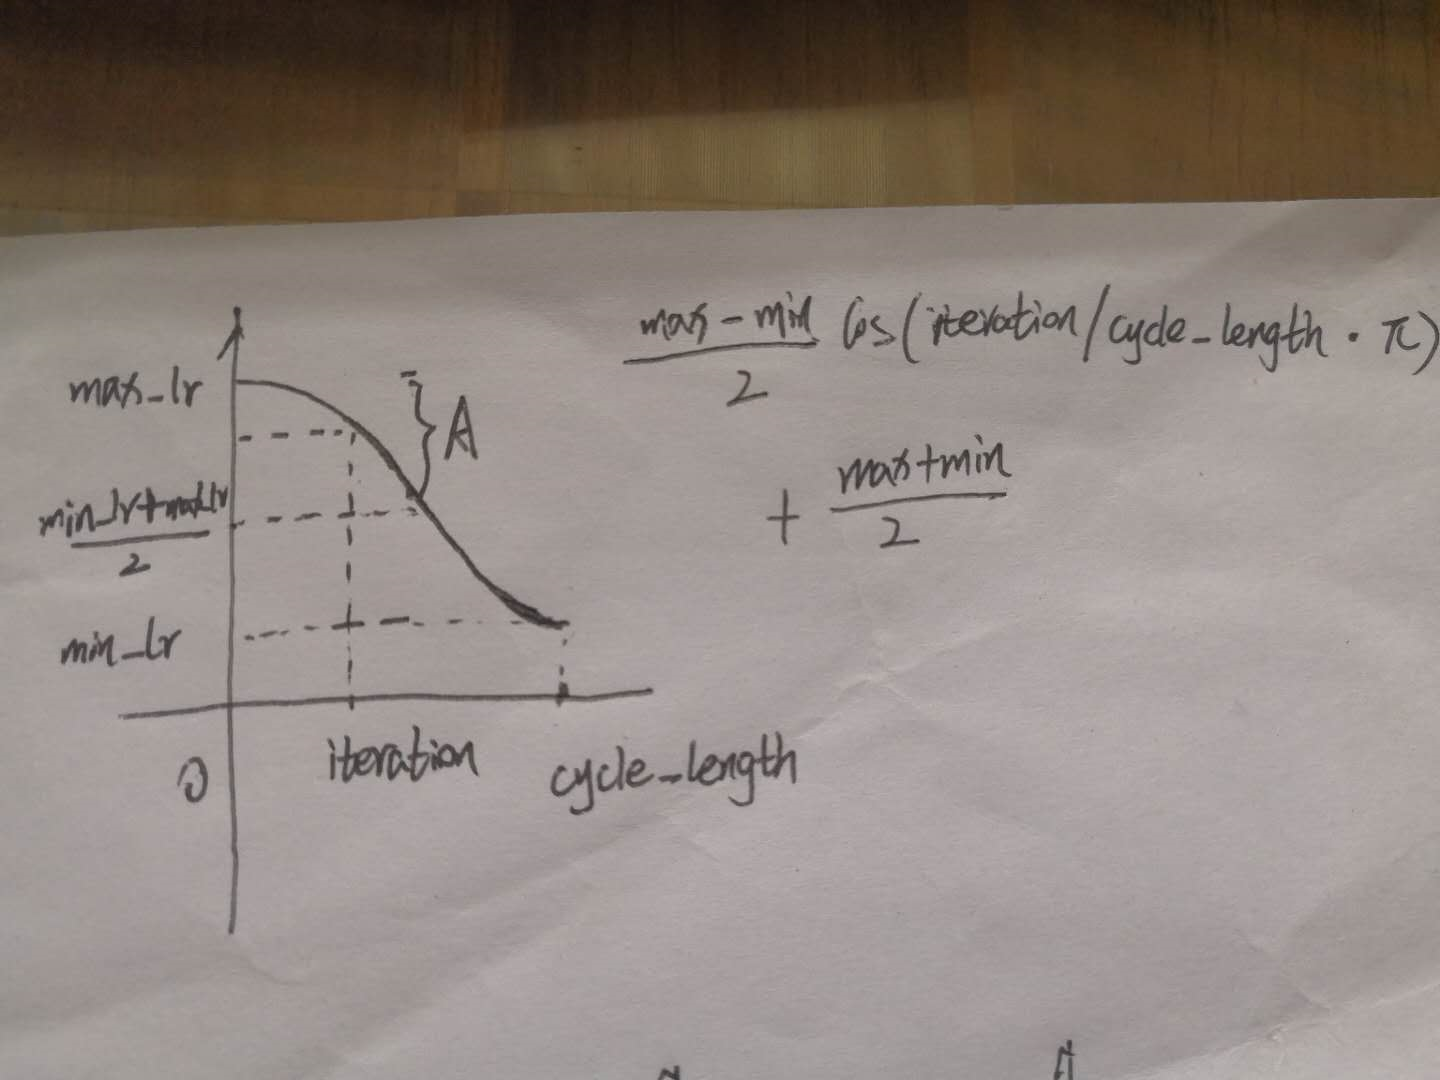

In [74]:
import math
class CosineAnnealingSchedule:
    def __init__(self, min_lr, max_lr, cycle_length):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
    
    def __call__(self, iteration):
        if iteration < self.cycle_length:
            return (self.max_lr + self.min_lr)/2 + (self.max_lr - self.min_lr)/2 * math.cos(iteration/self.cycle_length * math.pi)
        else:
            return self.min_lr

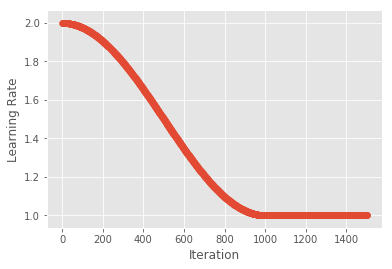

In [75]:
plot_schedule(CosineAnnealingSchedule(1, 2, 1000))

* CyclicalSchedule

In [96]:
class CyclicalSchedule:
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwags):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument.
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwags = kwags
        
    def __call__(self, iteration):
        end_curr_cycle = self.length
        cycle_length = self.length  # 保存当前的cycle_length
        cycle_idx = 0
        # 每当iteration超出当前cycle end(即第二个cycle起)，将cycle_end延后一个cycle_length
        while iteration >= end_curr_cycle:
            cycle_length = cycle_length * self.length_decay
            cycle_idx += 1  # 用于decay cycle_magnitude
            end_curr_cycle += cycle_length
        cycle_offset = iteration - (end_curr_cycle - cycle_length)
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwags)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

* SGDR

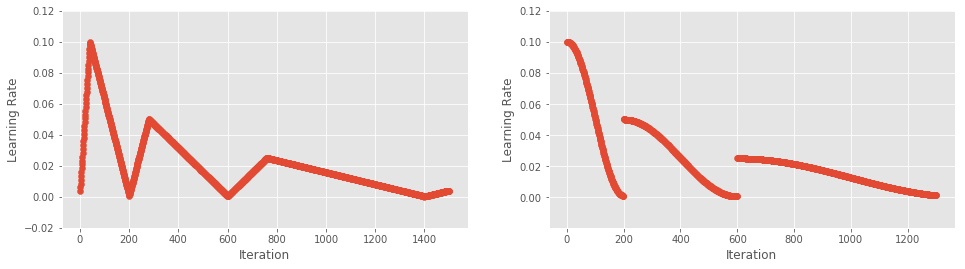

In [121]:
plt.figure(figsize=(16,4))
plt.subplot(121)
schedule = CyclicalSchedule(TrianguarSchedule, 200, cycle_length_decay=2, cycle_magnitude_decay=0.5,
                            min_lr=0.001, max_lr=0.1, in_fraction=0.2)
plot_schedule(schedule,1500)
plt.subplot(122)
schedule = CyclicalSchedule(CosineAnnealingSchedule, 200, cycle_length_decay=2, cycle_magnitude_decay=0.5,
                            min_lr=0.001, max_lr=0.1)
plot_schedule(schedule,1300)
plt.savefig('SGDR.png')

### 其他

* 一个有用的技巧是将linear warm start与其他basic schedule结合：

In [122]:
class LinearWarmUp():
    def __init__(self, schedule, start_lr, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        start_lr: learning rate used at start of the warm-up (float)
        length: number of iterations used for the warm-up (int)
        """
        self.schedule = schedule
        self.start_lr = start_lr
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.finish_lr = copy.copy(schedule)(0)
        self.length = length
    
    def __call__(self, iteration):
        if iteration <= self.length:
            return iteration * (self.finish_lr - self.start_lr)/(self.length) + self.start_lr
        else:
            return self.schedule(iteration - self.length)

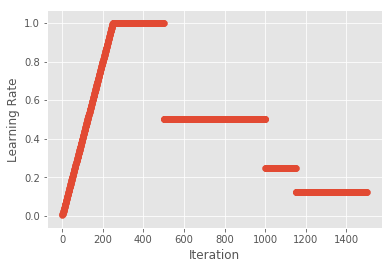

In [125]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
schedule = LinearWarmUp(schedule, start_lr=0, length=250)
plot_schedule(schedule)